In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/appie-mathematics/Deep-Hedging
%cd Deep-Hedging

Cloning into 'Deep-Hedging'...
remote: Enumerating objects: 426, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 426 (delta 62), reused 58 (delta 31), pack-reused 335
Receiving objects: 100% (426/426), 11.55 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (265/265), done.
/kaggle/working/Deep-Hedging


In [3]:
!git pull

Already up to date.


In [4]:
%ls

LICENSE  README.md  environment.yml  examples/  requirements.txt  src/


In [5]:
%cd src

/kaggle/working/Deep-Hedging/src


In [6]:
from typing import List
from matplotlib import pyplot as plt
import torch
from agents.Agent import Agent


from Costs import CostFunction, PorportionalCost
from agents.RecurrentAgent import RecurrentAgent
from agents.SimpleAgent import SimpleAgent
from instruments.Claims import Claim
from instruments.Derivatives import EuropeanCall, BSCall, BSPut, EuropeanPut
from instruments.Instruments import Instrument
from instruments.Primaries import GeometricBrownianStock, HestonStock
import RiskMeasures
from ExperimentRunner import ExperimentRunner, SimpleRunner, plot_dists

In [7]:
# Configuration
seed = 1337
torch.manual_seed(seed)

T = 30
total_rate = 0.0
step_interest_rate = (total_rate + 1) ** (1 / T) - 1
drift = step_interest_rate
volatility = 0.1
S0 = 1
stock = GeometricBrownianStock(S0, drift, volatility)
contingent_claim: Claim = BSCall(stock, S0, T, drift, volatility)
hedging_instruments: List[Instrument] = [stock]

criterion: torch.nn.Module = RiskMeasures.WorstCase()
prop_cost = 0.0
cost_function: CostFunction = PorportionalCost(prop_cost)
    
epochs = 200
paths = int(2e6)
h_dim = 15

verbose = False
animate = True
save = True
n = 10

Running on CUDA GPU


-2.340023994445801


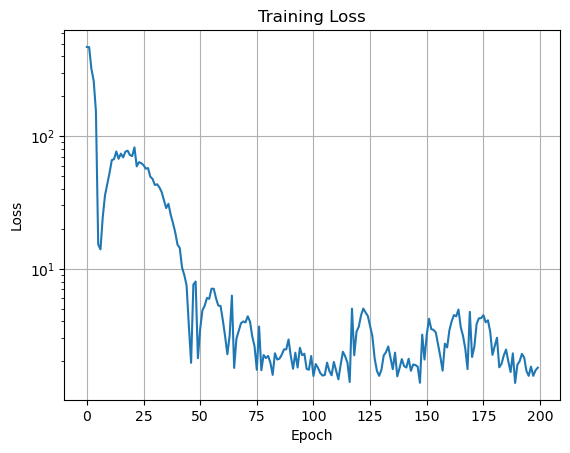

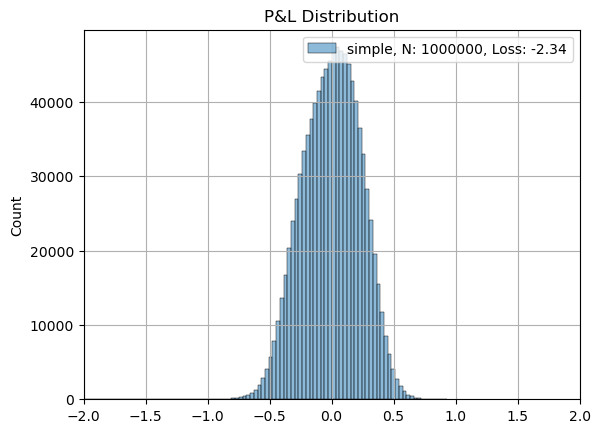

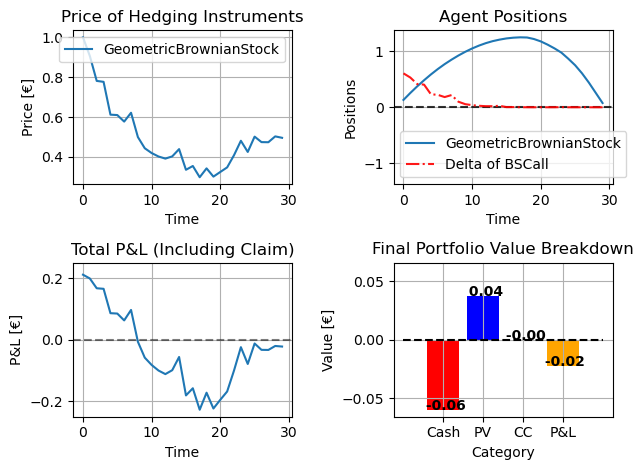

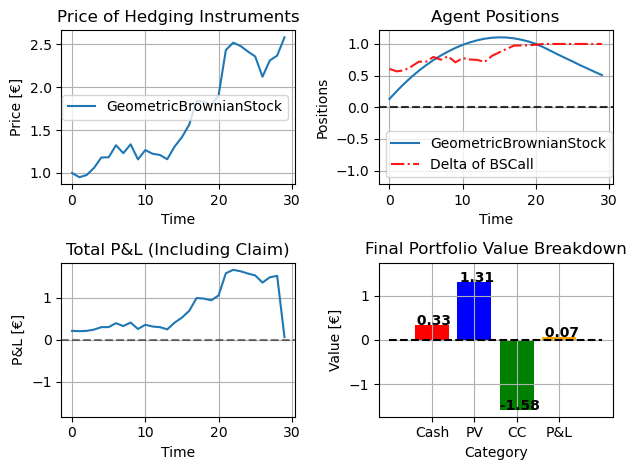

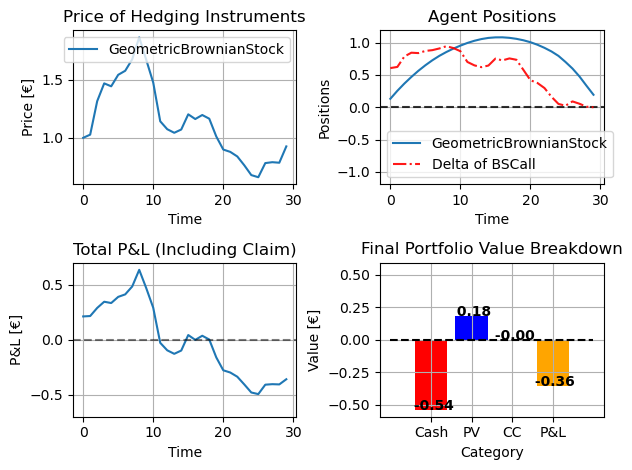

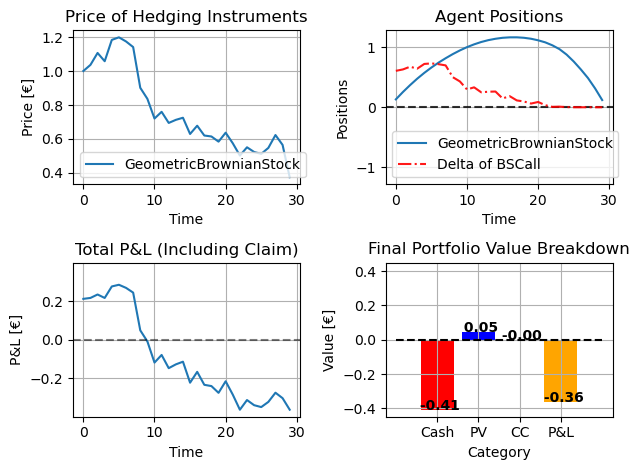

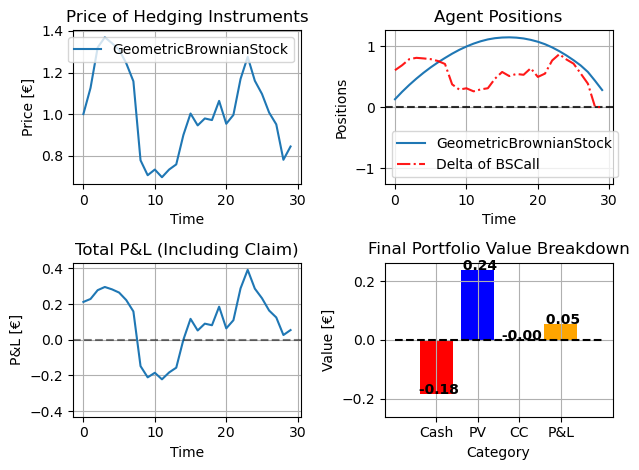

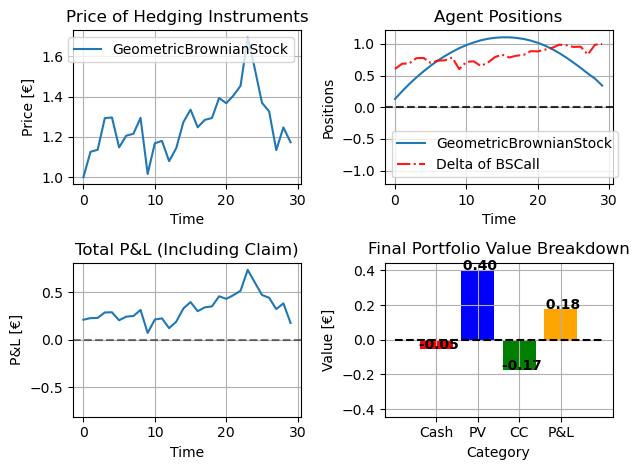

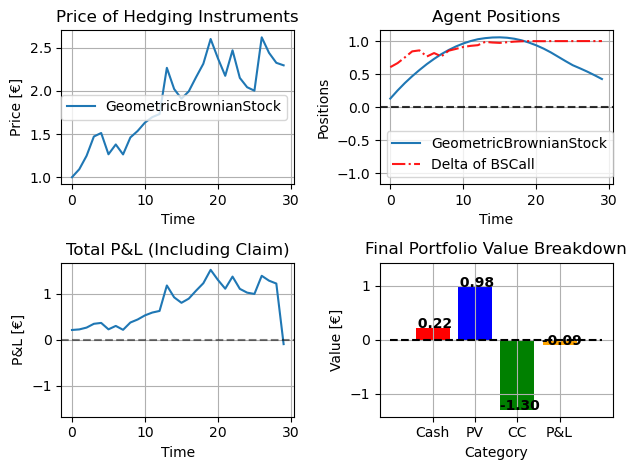

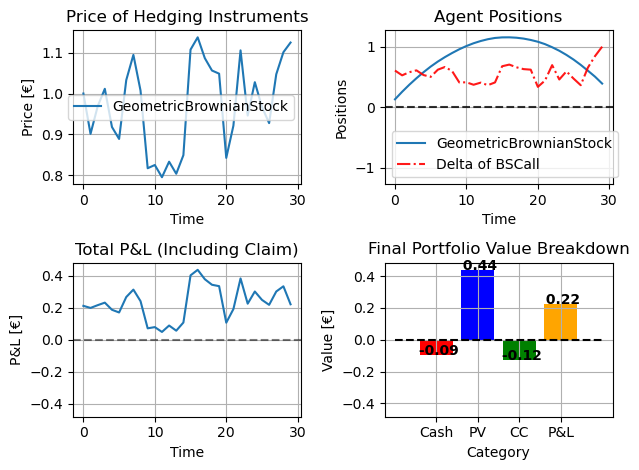

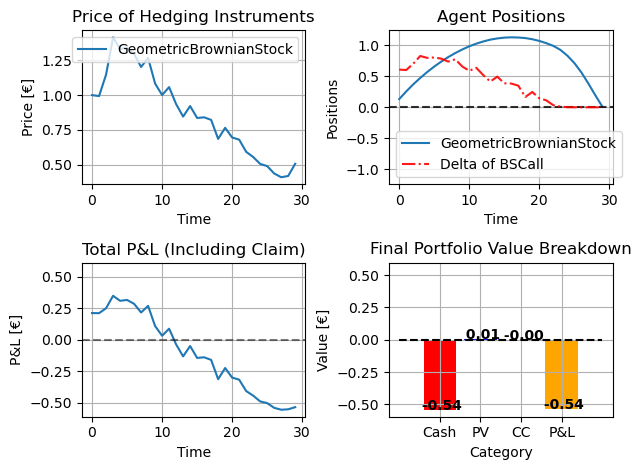

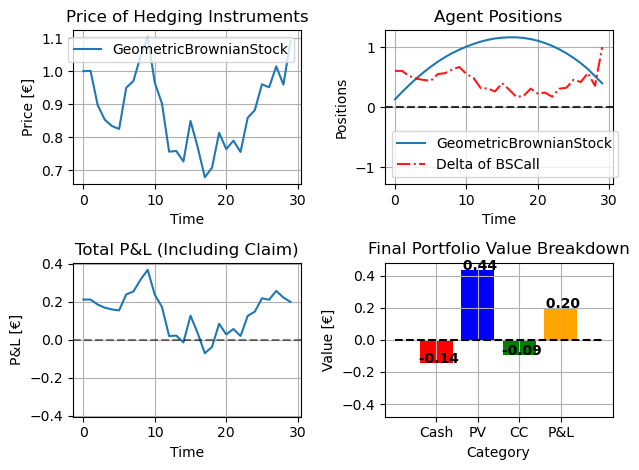

In [8]:
# Exp 1
simple_runner = ExperimentRunner("simple", pref_gpu=True)
res = simple_runner.run(contingent_claim, hedging_instruments, criterion, T, step_interest_rate, epochs, paths, verbose, cost_function, h_dim)
print(res)

output_folder = "/kaggle/working"
filename = f"{output_folder}/{simple_runner.agent_type}_hd_{h_dim}_e_{epochs}_p_{paths}_s_{seed}_pc_{prop_cost: .1f}"
simple_runner.plot_runner(animate=False, save=save, file_prefix=filename, n=n)

Running on CUDA GPU


-0.9873631596565247


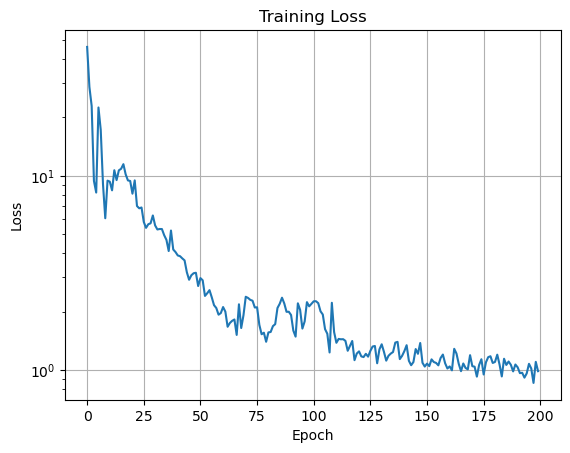

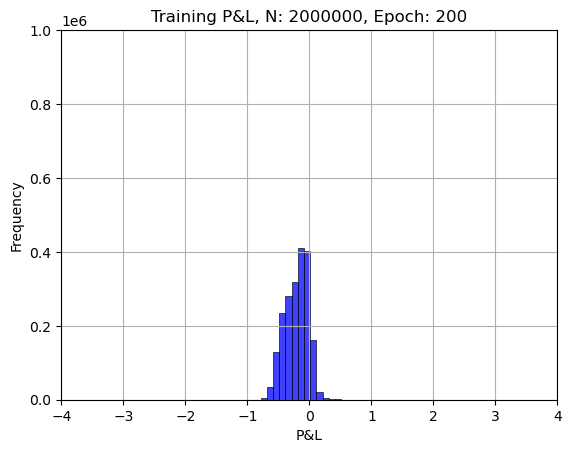

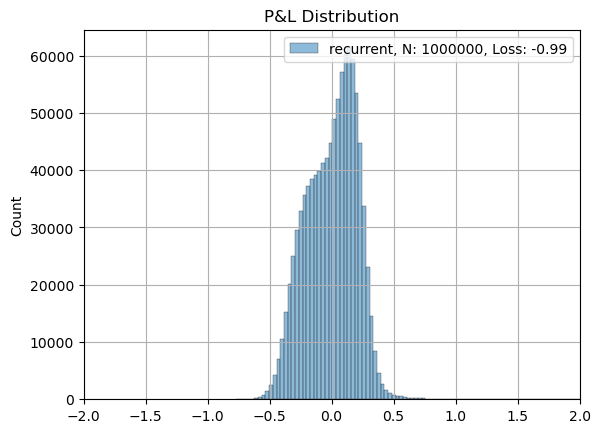

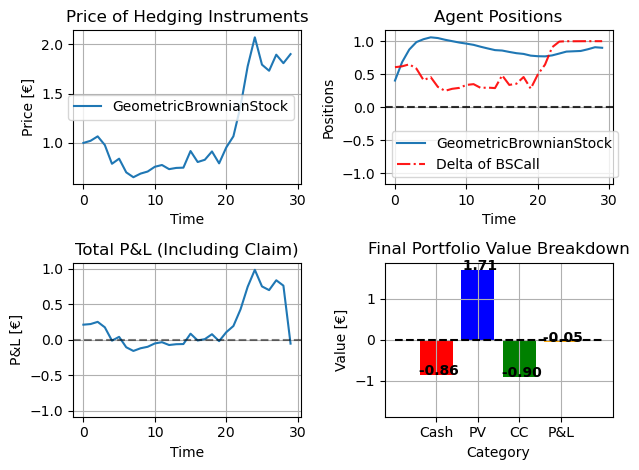

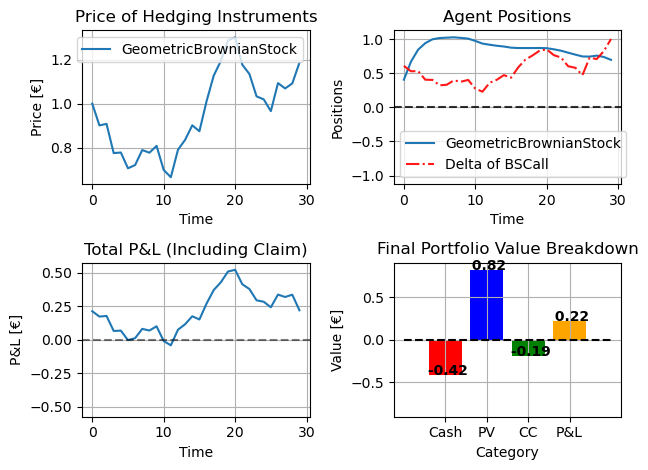

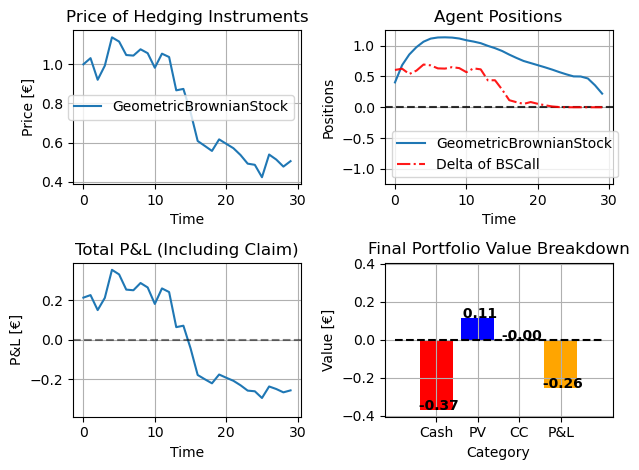

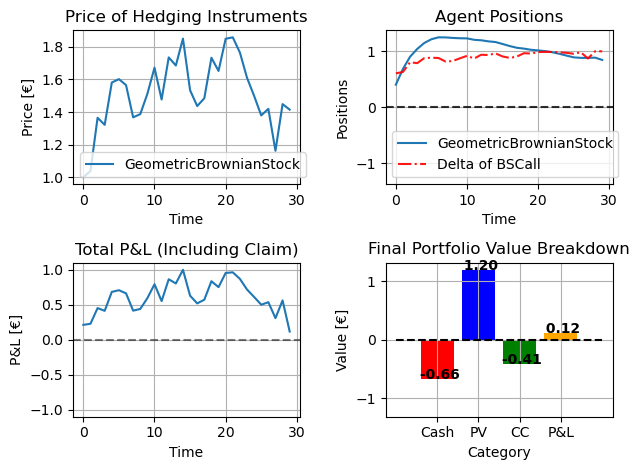

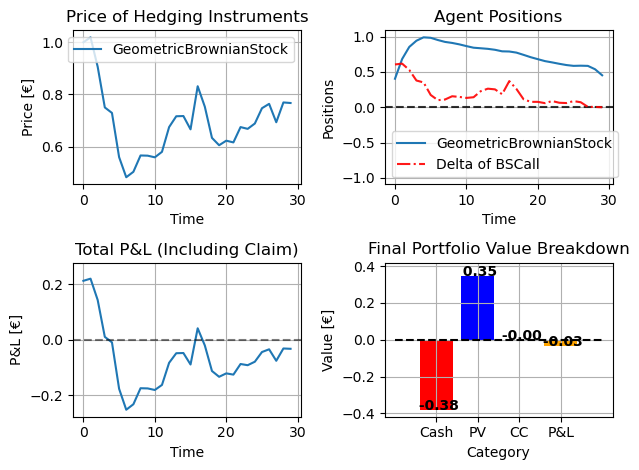

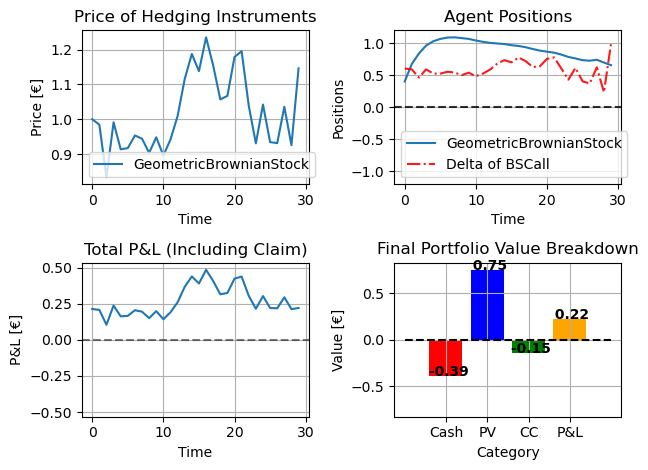

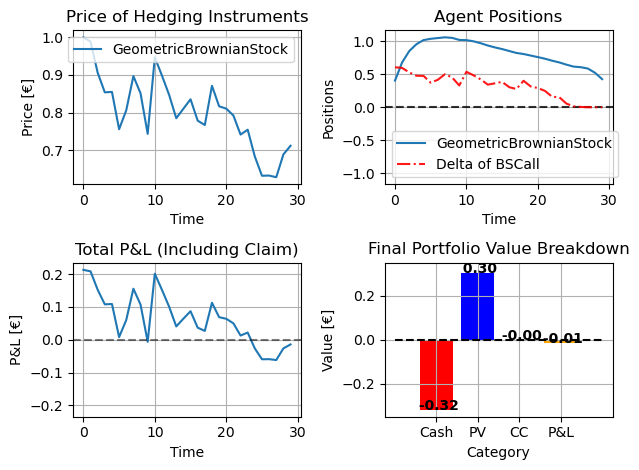

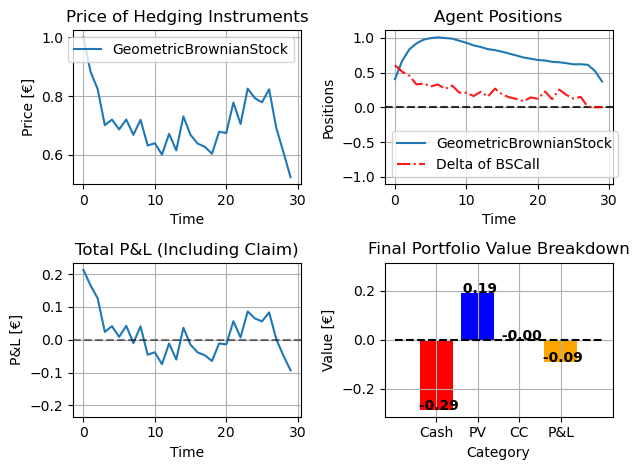

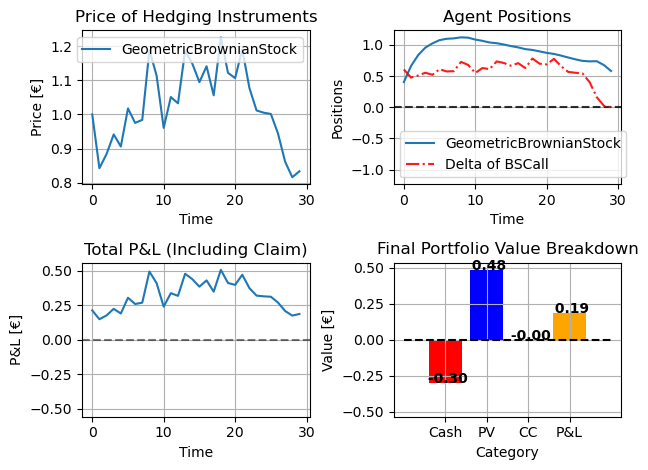

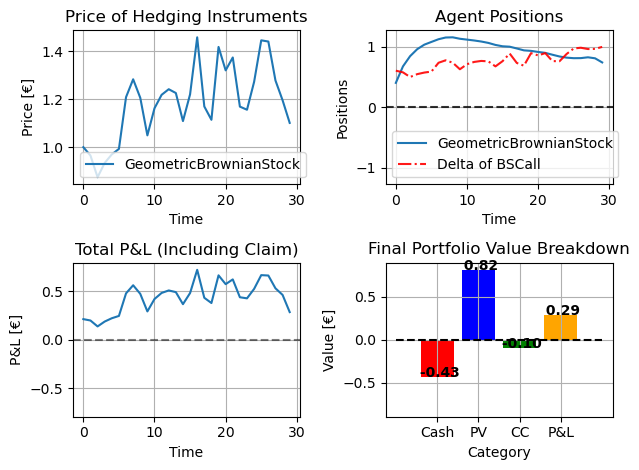

<Axes: title={'center': 'P&L Distribution'}, ylabel='Count'>

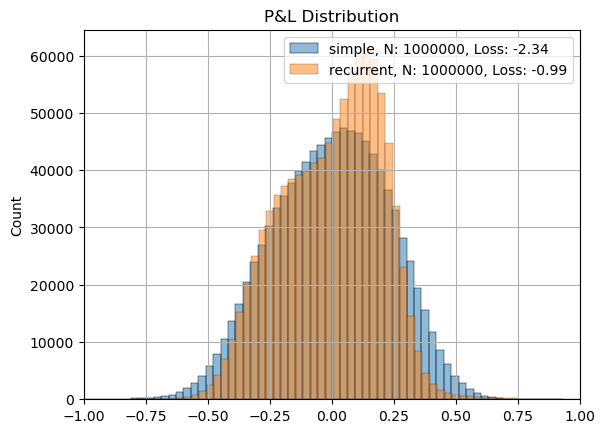

In [9]:
# Exp 2
recurrent_runner = ExperimentRunner("recurrent")
res = recurrent_runner.run(contingent_claim, hedging_instruments, criterion, T, step_interest_rate, epochs, paths, verbose, cost_function, h_dim)
print(res)

output_folder = "/kaggle/working"
filename = f"{output_folder}/{recurrent_runner.agent_type}_hd_{h_dim}_e_{epochs}_p_{paths}_s_{seed}_pc_{prop_cost: .1f}"
recurrent_runner.plot_runner(animate=animate, save=save, file_prefix=filename, n=n)
plot_dists([simple_runner, recurrent_runner], save=save, file_prefix=filename, x_lim=1)

Running on CUDA GPU
-0.5280816555023193


<Axes: title={'center': 'P&L Distribution'}, ylabel='Count'>

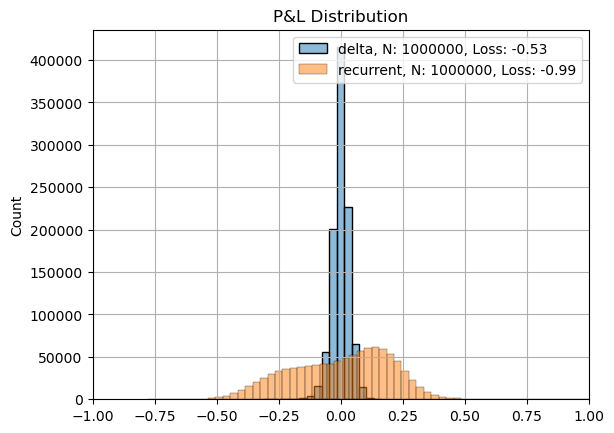

In [10]:
# Exp 3 Compare with delta hedge

stock_params = [S0, T, drift, volatility] #strike, expiry, rate, volatility
delta_runner = SimpleRunner("delta")
res = delta_runner.run(contingent_claim, hedging_instruments, criterion, T, step_interest_rate, epochs, paths, verbose, cost_function, extra_params=stock_params)
print(res)
plot_dists([delta_runner, recurrent_runner], save=save, file_prefix=filename, x_lim=1)